In [1]:
!pip install finance-datareader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from PIL import Image
import random

DAY_NUM = 32 # DAY_NUM거래일만큼의 차트 비교

In [4]:
def convert_image(data, num_images, day_num, name, code, save = False):

    def alpha_blend(color1, color2, alpha):
        return [
            int((color1[0] * alpha + color2[0] * (1 - alpha))),
            int((color1[1] * alpha + color2[1] * (1 - alpha))),
            int((color1[2] * alpha + color2[2] * (1 - alpha)))
        ]
    if len(data) < day_num:
        print("종목 데이터 부족")
        return []

    if num_images > len(data) - day_num + 1:
        num_images = len(data) - day_num + 1


    return_datas = []
    image_idx = 1
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]
        # 이미지 크기 설정
        width, height = day_num * 3, 96

        # High, Low, Close, Volume 데이터 정규화
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values
        open_prices = stock_data['Open'].values
        close_prices = stock_data['Close'].values

        high_prices_norm = (high_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        low_prices_norm = (low_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        open_prices_norm = (open_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        close_prices_norm = (close_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))

        # if len(data) <= abs(-image_idx - day_num - 18):
        #     break

        # # 이동평균선 추가를 위한 stock_data 생성
        # if image_idx != 1:
        #     stock_data_ma20 = data[-image_idx - day_num - 18: -image_idx + 1]
        # else:
        #     stock_data_ma20 = data[-image_idx - day_num - 18: ]

        # stock_data_ma20 = stock_data_ma20.copy()
        # stock_data_ma20['MA20'] = stock_data_ma20['Close'].rolling(window=20).mean()
        # stock_data_ma20.dropna(inplace=True)

        # # 이동평균선 값을 정규화
        # stock_data_ma20['MA20_norm'] = (
        #         (stock_data_ma20['MA20'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        #     )


        # 96x96 이미지 생성
        img = np.ones((height, width, 3), dtype=np.uint8) * 255

        fail_generate = False
        for day in range(day_num):
            high_price = int(high_prices_norm[day] * (height - 1))
            low_price = int(low_prices_norm[day] * (height - 1))
            close_price = int(close_prices_norm[day] * (height - 1))
            open_price = int(open_prices_norm[day] * (height - 1))

            x_start = day * 3

            # 시가, 종가, 고가, 저가 막대그래프
            # 막대 왼쪽, 오른쪽 그리기 (시가, 종가 범위)
            for x in range(x_start, x_start + 3):
                if close_prices[day] > stock_data['Open'].values[day]:
                    color = [255, 0, 0]  # 상승: 빨강
                    tail_color = [200, 0, 0]  # 상승 시 꼬리: 어두운 빨강
                elif close_prices[day] < stock_data['Open'].values[day]:
                    color = [0, 0, 255]  # 하락: 파랑
                    tail_color = [0, 0, 200]  # 하락 시 꼬리: 어두운 파랑
                else: # 시가와 종가가 같을경우 어제보다 같거나 올랐으면 빨강, 아니면 파랑
                    if 0 <= stock_data['Change'].values[day]:
                        color = [255, 0, 0]  # 상승: 빨강
                        tail_color = [200, 0, 0]  # 상승 시 꼬리: 어두운 빨강
                    else:
                        color = [0, 0, 255]  # 하락: 파랑
                        tail_color = [0, 0, 200]  # 하락 시 꼬리: 어두운 파랑

                for y in range(min(open_price, close_price), max(open_price, close_price) + 1):
                    img[height - 1 - y, x] = color

            # 꼬리 그리기 (High, Low 범위)
            for x in range(x_start + 1, x_start + 2):
                for y in range(low_price, high_price + 1):
                    if img[height - 1 - y, x][0] != 0 and img[height - 1 - y, x][2] != 0:
                        img[height - 1 - y, x] = tail_color

            # # 20일 이동평균선 그리기
            # ma20_norm = stock_data_ma20.iloc[day]['MA20_norm']

            # for x in range(x_start, x_start + 3):
            #     if not np.isnan(ma20_norm):
            #         ma20_y = int(ma20_norm * (height - 1))
            #         if 0 <= ma20_y < height:
            #             for y in range(ma20_y - 1, ma20_y + 2):  # 이동평균선 주변에 블렌딩 처리
            #                 if 0 <= y < height:
            #                     new_color = alpha_blend([255, 255, 0], img[height - 1 - y, x], 0.4)  # 노란색으로 변경
            #                     img[height - 1 - y, x] = new_color

        #이미지가 day_num(그려지기 원하는 거래일 수)미만으로 그려졌으면
        if fail_generate:
            image_idx += 1
            continue

        if save :
            # 이미지 저장
            nimg = Image.fromarray(img, 'RGB')
            nimg.save(f'stock_data_image_{image_idx}.png')


        return_datas.append((img, name, code, stock_data.index[-1]))

        image_idx += 1


    return return_datas

In [5]:
def preprocess_data(data):
    # 0이나 NaN을 포함하는 행 제거
    data = data[data['Volume'] != 0]
    data = data.dropna(how='any')

    return data

In [6]:
class StockData:
    def __init__(self, open_prices, close_prices, high_prices, low_prices, max_volume_idx, max_hi_lo_diff_idx, name, code, date):
        self.open_prices = open_prices
        self.close_prices = close_prices
        self.high_prices = high_prices
        self.low_prices = low_prices
        self.max_volume_idx = max_volume_idx
        self.max_hi_lo_diff_idx = max_hi_lo_diff_idx
        self.name = name
        self.code = code
        self.date = date

In [29]:
RIGHT_QUARTILE = 8 # 맨 마지막 종가를 몇분위로 나눌건지
LEFT_QUARTILE = 8

def convert_norm(data, num_images, day_num, name, code, save=False):
    global open_close_data

    if len(data) < day_num:
        print("종목 데이터 부족")
        if save:
            return 0
        else:
            return [[-1, -1, -1, -1, -1, -1]]

    if num_images > len(data) - day_num + 1:
        num_images = len(data) - day_num + 1

    return_data = []
    image_idx = 1
    cnt = 0
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]

        open_prices = stock_data['Open'].values
        close_prices = stock_data['Close'].values
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values

        highest_prices = high_prices.max()
        lowest_prices = low_prices.min()
        hi_lo_diff = highest_prices - lowest_prices
        if hi_lo_diff == 0:
            image_idx += 1
            continue

        open_prices_norm = (open_prices - lowest_prices) / (hi_lo_diff)
        close_prices_norm = (close_prices - lowest_prices) / (hi_lo_diff)
        high_prices_norm = (high_prices - lowest_prices) / (hi_lo_diff)
        low_prices_norm = (low_prices - lowest_prices) / (hi_lo_diff)
        high_low_diff = high_prices_norm - low_prices_norm

        max_idx = np.argmax(high_prices_norm)
        min_idx = np.argmin(low_prices_norm)
        max_hi_lo_diff_idx = np.argmax(high_low_diff)
        first_close_idx = min(np.digitize(close_prices_norm[0], np.linspace(0, 1, LEFT_QUARTILE + 1)) - 1, LEFT_QUARTILE - 1)
        last_close_idx = min(np.digitize(close_prices_norm[-1], np.linspace(0, 1, RIGHT_QUARTILE + 1)) - 1, RIGHT_QUARTILE - 1)

        volume_data = stock_data['Volume'].values
        max_volume_idx = np.argmax(volume_data)

        image_idx += random.choice(range(1,4))
        cnt += 1

        if save:
            open_close_data[max_idx][last_close_idx][min_idx][first_close_idx][max_hi_lo_diff_idx].append(StockData(open_prices_norm, close_prices_norm, high_prices_norm, low_prices_norm, max_volume_idx, max_hi_lo_diff_idx, name, code, str(stock_data.index[-1])[:10]))
        else:
            return_data.append([max_idx, last_close_idx, min_idx, first_close_idx, max_hi_lo_diff_idx, StockData(open_prices_norm, close_prices_norm, high_prices_norm, low_prices_norm, max_volume_idx, max_hi_lo_diff_idx, name, code, str(stock_data.index[-1])[:10])])

    if save:
        return cnt
    else:
        return return_data

In [8]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/codes.csv', usecols=[0, 1], dtype={0: str})
# 첫 번째 열과 두 번째 열을 Nx2 리스트로 변환
stock_codes = df.values.tolist()

# 결과 출력
print(stock_codes)

[['095570', 'AJ네트웍스'], ['006840', 'AK홀딩스'], ['054620', 'APS'], ['265520', 'AP시스템'], ['211270', 'AP위성'], ['027410', 'BGF'], ['282330', 'BGF리테일'], ['126600', 'BGF에코머티리얼즈'], ['138930', 'BNK금융지주'], ['001460', 'BYC'], ['001465', 'BYC우'], ['013720', 'CBI'], ['083790', 'CG인바이츠'], ['001040', 'CJ'], ['079160', 'CJ CGV'], ['035760', 'CJ ENM'], ['311690', 'CJ 바이오사이언스'], ['00104K', 'CJ4우(전환)'], ['000120', 'CJ대한통운'], ['011150', 'CJ씨푸드'], ['011155', 'CJ씨푸드1우'], ['001045', 'CJ우'], ['097950', 'CJ제일제당'], ['097955', 'CJ제일제당 우'], ['051500', 'CJ프레시웨이'], ['058820', 'CMG제약'], ['023460', 'CNH'], ['056730', 'CNT85'], ['000480', 'CR홀딩스'], ['065770', 'CS'], ['083660', 'CSA 코스믹'], ['000590', 'CS홀딩스'], ['012030', 'DB'], ['404950', 'DB금융스팩10호'], ['456440', 'DB금융스팩11호'], ['367360', 'DB금융스팩9호'], ['016610', 'DB금융투자'], ['005830', 'DB손해보험'], ['000990', 'DB하이텍'], ['139130', 'DGB금융지주'], ['060900', 'DGP'], ['025440', 'DH오토웨어'], ['001530', 'DI동일'], ['000210', 'DL'], ['001880', 'DL건설'], ['000215', 'DL우'], ['375500', 'DL이앤씨'

In [9]:
import pickle

# with open("drive/MyDrive/Colab Notebooks/stock_data_20150101-20230915.pkl", "wb") as f:
    # pickle.dump(stock_data, f)

with open("drive/MyDrive/Colab Notebooks/stock_data_20150101-20230915.pkl", "rb") as f:
    stock_data = pickle.load(f)

In [31]:
none_stock_data = preprocess_data(fdr.DataReader('005930', '1900-01-01', '1900-01-01'))

def get_stock_data_se(code, start_date, end_date='2023-09-15'):
    global stock_data, none_stock_data

    return stock_data[code].loc[start_date : end_date]

def get_stock_data(code, date, preceeding = 0, following = 0):
    global stock_data, none_stock_data

    if date not in stock_data[code].index:
        return none_stock_data

    index_location = stock_data[code].index.get_loc(date)
    if index_location - preceeding < 0:
        print('앞쪽 데이터 부족')
        return none_stock_data
    if index_location + following > len(stock_data[code]):
        print('뒤쪽 데이터 부족')
        return none_stock_data


    start_location = index_location - preceeding
    end_location = min(len(stock_data[code]), index_location + following + 1)

    return stock_data[code].iloc[start_location : end_location]

In [21]:
# stock_data = {code : 0 for code, name in stock_codes}

# cnt_sum = 0
# for i, ticker in enumerate(stock_codes):
#     code, name = ticker[0], ticker[1]
#     print(f"{i+1}번째 종목 {name} 추출중...   ")
#     stock_data[code] = preprocess_data(fdr.DataReader(code, '2015-01-01', '2023-09-15'))
#     cnt_sum += len(stock_data[code])
#     print(f"{len(stock_data[code])}개 추출 / 총{cnt_sum}개")

In [ ]:
open_close_data = [[[[[[] for _ in range(DAY_NUM)] for _ in range(LEFT_QUARTILE)] for _ in range(DAY_NUM)] for _ in range(RIGHT_QUARTILE)] for _ in range(DAY_NUM)]
def process():
    global open_close_data
    cnt_sum = 0
    for i, ticker in enumerate(stock_codes):
        code, name = ticker[0], ticker[1]
        print(f"{i+1}번째 종목 {name} 추출중...   ")

        try:
            data = stock_data[code]  # 각 종목의 데이터 가져오기
            cnt = convert_norm(get_stock_data_se(code, '2016-01-01'), 3000, DAY_NUM, name, code, save=True)
            cnt_sum += cnt
            print(f"{cnt}개 추출 / 총{cnt_sum}개")

        except IndexError:
            print(f"{name}에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.")
            continue

process()

In [11]:
import pickle

# with open("drive/MyDrive/Colab Notebooks/2016.pkl", "wb") as f:
    # pickle.dump(open_close_data, f)

with open("drive/MyDrive/Colab Notebooks/2016.pkl", "rb") as f:
    open_close_data = pickle.load(f)

In [84]:
 # Create a weight array that gives more weight to later elements
def rmse(predictions, targets, max_volume_idx):
    weights = np.linspace(1, 2, DAY_NUM)

    weights[max_volume_idx] *= 16 # 거래량이 제일 많은 날은 가중치 더 크게
    if max_volume_idx + 1 < DAY_NUM:
        weights[max_volume_idx+1] *= 4
    if max_volume_idx - 1 >= 0:
        weights[max_volume_idx-1] *= 4

    # Calculate the squared errors
    squared_errors = ((predictions - targets) ** 2)

    # Apply the weights to the squared errors
    weighted_squared_errors = weights * squared_errors

    # Calculate the mean and square root
    return np.sqrt(weighted_squared_errors.mean())

In [138]:
import numpy as np
import heapq

similar = {code : [] for code, name in stock_codes}  # 유사한 이미지들을 저장할 리스트

code_cnt = 1
for code, name in stock_codes[:1]:
    code_cnt += 1
    print(f'{cnt}번째 종목 {name} ', end='')
    code = '001200'
    # up, right, down, left, latest_data = convert_norm(preprocess_data(fdr.DataReader(code, '2023-04-15', '2023-09-16')), 1, DAY_NUM, name, code)[0]
    up, right, down, left, m, latest_data = convert_norm(get_stock_data(code, '2023-09-15', preceeding=31), 1, DAY_NUM, name, code)[0]

    cnt = 0
    if up == -1:
        print(f"{cnt} 개 추출")
        continue

    high_low_diff = np.argsort(latest_data.high_prices - latest_data.low_prices)[::-1][:3]

    for u in range(max(up - 1, 0), min(up + 2, DAY_NUM)):
        for r in range(max(right - 1, 0), min(right + 2, RIGHT_QUARTILE)):
            for d in range(max(down - 2, 0), min(down + 3, DAY_NUM)):
                for l in range(max(left - 2, 0), min(left + 3, LEFT_QUARTILE)):
                    for hl in high_low_diff:
                        for data in open_close_data[u][r][d][l][hl]:
                            dif = rmse(latest_data.open_prices, data.open_prices, latest_data.max_volume_idx) + rmse(latest_data.close_prices, data.close_prices, latest_data.max_volume_idx) + rmse(latest_data.high_prices, data.high_prices, latest_data.max_volume_idx) + rmse(latest_data.low_prices, data.low_prices, latest_data.max_volume_idx)
                            # (유사도 음수값, 데이터) 형태로 힙에 추가합니다.
                            heapq.heappush(similar[code], [-dif, data])

                            # similar 리스트의 크기가 100을 초과하면 가장 작은 원소(즉, 유사도가 가장 낮은 원소)를 제거합니다.
                            if len(similar[code]) > 20:
                                heapq.heappop(similar[code])

                            cnt += 1

    print(f"{cnt} 개 추출")
    similar[code].sort(reverse=True)

1111번째 종목 AJ네트웍스 5406 개 추출


In [139]:
from datetime import datetime, timedelta

similar_images = {code : [] for code, name in stock_codes}
for code, name in stock_codes[:1]:
    code = '001200'
    for dif, data in similar[code]:

        stock = get_stock_data(data.code, data.date, preceeding=31)  # 각 종목의 데이터 가져오기
        image = convert_image(stock, 1, DAY_NUM, data.name, data.code)

        if len(image) == 0:
            continue

        data.image = image[0][0]
        similar_images[code].append((dif, data))
        print(len(similar_images[code]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


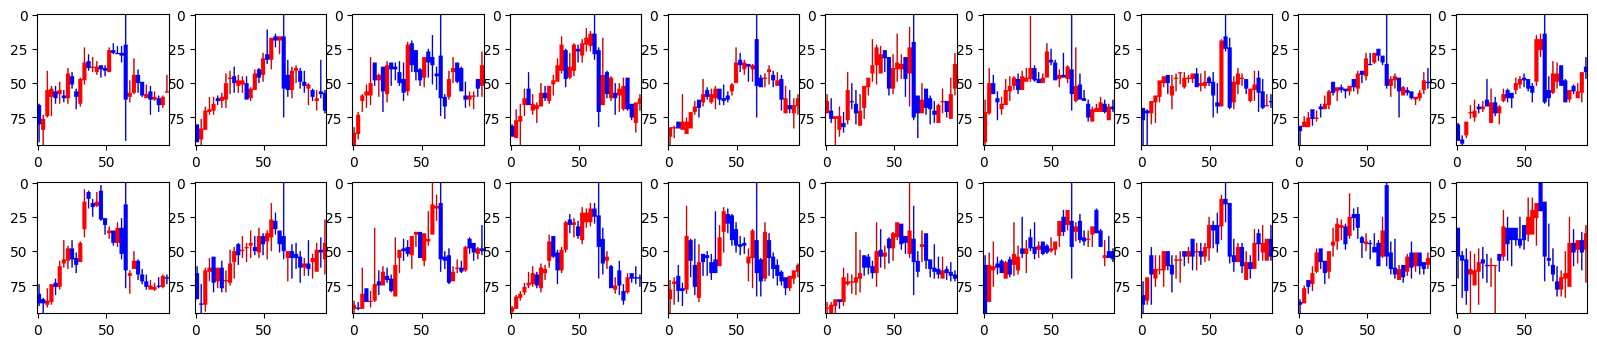

-0.0 유진투자증권 2023-09-15
-0.6765550790648158 한양이엔지 2016-06-16
-0.7375461775314993 지엔씨에너지 2021-02-16
-0.7647116238847103 플레이위드 2022-05-03
-0.8039971981872869 아시아경제 2019-05-15
-0.8532366531047899 토비스 2017-11-24
-0.8598041939150143 아이윈 2021-09-30
-0.872136933529074 예스24 2018-12-26
-0.8721871098203077 와이어블 2022-04-21
-0.8808021590813369 에코볼트 2017-10-13
-0.8918084524296505 OCI 2023-08-10
-0.9068801612912587 애니젠 2021-05-13
-0.9140579943793924 삼아제약 2016-06-09
-0.9212486231654717 디엔에프 2023-08-24
-0.9296800473875079 한국선재 2021-02-17
-0.940390989207406 전방 2021-02-16
-0.9481601421547752 와이어블 2020-07-28
-0.9483066742938429 삼일 2023-02-24
-0.9623819527411593 헥토이노베이션 2018-01-05
-0.9715035273201744 동원금속 2016-08-26


In [140]:
import matplotlib.pyplot as plt
import math

code = '001200'
latest_image = convert_image(get_stock_data(code, '2023-09-15', preceeding=31), 1, DAY_NUM, '삼성전자', '005930')[0][0]

# 한 행에 표시될 서브플롯 수 (예: 4개)
cols = 10

# 필요한 행 수 계산
rows = math.ceil(len(similar_images[code]) / cols)

# 새로운 figure 생성
plt.figure(figsize=(20, rows * 2))

# 모든 유사한 이미지 출력
i = 0
for dif, data in similar_images[code]:
    plt.subplot(rows, cols, i+1)
    plt.imshow(data.image)
    # plt.axis('off')  # 축 제거
    i += 1

plt.show()
for dif, data in similar_images[code][:20]:
    print(dif, data.name, data.date)